# pySPaRTAN: a Python computational framework for linking cell-surface receptors to transcriptional regulators

## Introduction

Cell identity and function depend on complex signaling and transcriptional programs. Advances in single-cell technology have enabled the analysis of transcriptional states coupled with cell surface receptor expression. This tutorial will demonstrate the usage of our computational framework pySPaRTAN, a Python implementation of the SPaRTAN (Single-cell Proteomic and RNA-based Transcription factor Activity Network). SPaRTAN models the flow of information from cell-surface receptors to transcription factors (TFs), then regulate target genes. It utilizes CITE-seq data, which includes cell surface protein and gene expression, to infer TF activity.

SPaRTAN is available at https://academic.oup.com/nar/article/49/17/9633/6368058.

<img src="pySPaRTAN_diagram_1.png" alt="Diagram" width="600" />

## Environment setup

Please download the repository and follow the "Environment Setup" section in README.txt to install the Conda environment, JupyterLab, and Python packages listed in requirements_pyspartan.txt.

pySPaRTAN is a Python-based model. To enhance runtime performance, we converted certain computationally intensive Python functions into two Cython modules. Since Cython is platform-dependent, we need to build the Cython objects on site.

In [ ]:
# building two Cython objects
! python  setup.py build_ext --inplace

If you encounter any issues while generating Cython objects, please refer to our pySPaRTAN GitHub page at https://github.com/osmanbeyoglulab/SPaRTAN/tree/main/pySPaRTAN for detailed instructions.

After successfully building the Cython objects, there are two .so files generated on a Mac/Linux machine or .pyd files on a Windows machine.

In [3]:
! ls 

build                              pySPaRTAN.py
cythKronPlus                       pySPaRTAN_diagram_1.png
cythKronPlus.cpython-312-darwin.so pySPaRTAN_diagram_2.png
cythLeastR                         pySPaRTAN_diagram_3.png
cythLeastR.cpython-312-darwin.so   pySPaRTAN_tutorial.ipynb
equation_1.png                     setup.py


Note: using "ls" command on Mac/Linux computer; "dir" command on Windows computer.

Now we import the python packages used in this tutorial.

In [4]:
import scanpy as sc
from muon import prot as pt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from IPython.display import display, HTML
from itertools import chain
from adjustText import adjust_text

from pySPaRTAN import pySPaRTAN

## Data pre-processing
### Data loading

We demonstrate the pipeline using the CITE-seq dataset of Peripheral Blood Mononuclear Cells (PBMC), which is freely available from 10X Genomics. 

We load the raw counts data saved in the .h5 file.

In [5]:
adata=sc.read_10x_h5("../data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
# making the variable name unique
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 5527 × 33570
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [6]:
set(adata.var["feature_types"])

{'Antibody Capture', 'Gene Expression'}

The ADT and RNA data are both stored in this adata object, differentiated by the "feature_types" variable. We will separate them into two distinct objects for ease of processing.

In [7]:
# extracting gene expression raw counts
RNA = adata[:, adata.var["feature_types"] == "Gene Expression"]

In [8]:
# extracting ADT raw counts
ADT = adata[:,adata.var["feature_types"]=="Antibody Capture"].copy()

# removing the isotype control for antibody
ADT=ADT[:,[x for x in ADT.var_names if "control" not in x]]

### Quality control

We calculate QC matrix and inspect the following features:

* the number of genes expressed in the count matrix

* the total counts per cell

* the percentage of counts in mitochondrial genes

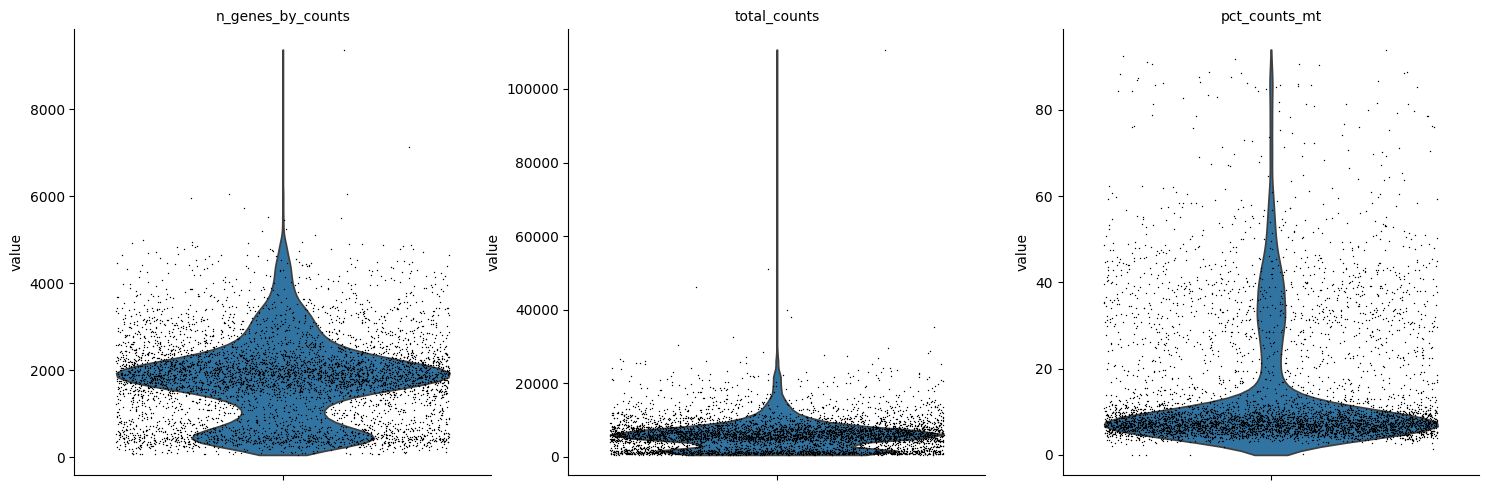

In [9]:
RNA.var['mt'] = RNA.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(RNA, qc_vars=['mt'], percent_top=None, log1p=False,inplace=True)

sc.pl.violin(
    RNA,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Based on QC metric plots, we filter out cells with fewer than 1,000 or more than 5,000 unique gene sequences, as well as cells with more than 30% mitochondrial counts. Additionally, we exclude genes that are not present in at least 3% of cells. we also remove all mitochondrial genes from the dataset.

In [10]:
# filtering mRNA cells
sc.pp.filter_cells(RNA, min_genes=1000)
RNA=RNA[RNA.obs.query("n_genes_by_counts < 5000 and pct_counts_mt<30").index]

# filtering mRNA genes
sc.pp.filter_genes(RNA, min_cells=0.03*RNA.n_obs)

# removing all mitochondrial genes from the dataset
RNA=RNA[:, RNA.var['mt']==False]

# filtering cells of ADT according to RNA
ADT = ADT[RNA.obs_names, :]

### Normalization

We scale the mRNA raw counts to a sum of 1e4 and normalize it with log1p transformation. 

In [11]:
sc.pp.normalize_total(RNA, target_sum=10000)
sc.pp.log1p(RNA)

For the protein, we normalize the raw counts using the center log ratio (CLR) transformation with the clr function from the Muon package.

In [12]:
pt.pp.clr(ADT)

## Cell type annotation

The pySPaRTAN model performs best when applied to data from different cell types separately. Next, we we will proceed with preparing to annotate cell types.

Before further processing, we save the log-normalized mRNA data which will serve as input for pySPaRTAN.

In [13]:
RNA.layers['log1p'] = RNA.X.copy()

### Feature selection
We subset features that only include highly variable genes. Focusing on these genes in downstream analysis helps emphasize biological signals in single-cell datasets.

We identify highly variable features and return top 5000 genes.

In [14]:
sc.pp.highly_variable_genes(RNA, n_top_genes=5000)

### Dimensionality Reduction
Before reducing the dimensionality of the data, we scale it such that the mean expression is 0 and the variance is 1 across cells.

In [15]:
sc.pp.scale(RNA)

We apply principal component analysis with default setting (return top 50 principal components).

In [16]:
sc.tl.pca(RNA)

To determine how many principal components we should choose to compute the neighborhood relations of the cells, we inspect the contribution of individual PCs to the total variance in the data.

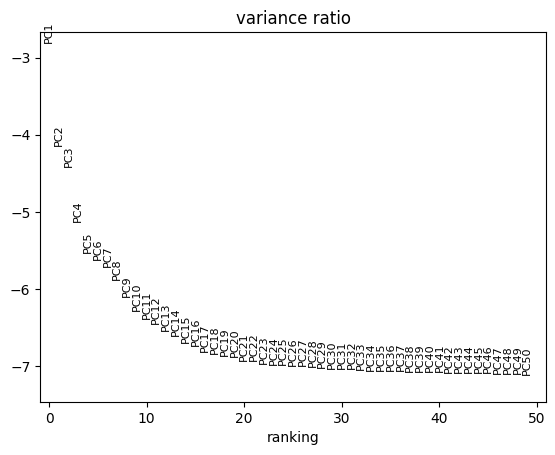

In [17]:
sc.pl.pca_variance_ratio(RNA, n_pcs=50, log=True)

From the above plot, we observe that the first 20-30 principal components capture the majority of variance.

### Clustering

First we construct a KNN graph based on the euclidean distance in PCA space.

In [18]:
sc.pp.neighbors(RNA, n_neighbors=20, n_pcs=20)

Next we cluster cells using  Leiden algorithm which is considered as an improved version of the Louvain algorithm.

In [19]:
sc.tl.leiden(RNA, flavor="igraph", n_iterations=2, resolution=1)

Then we embed neighborhood graph into two-dimensional space using UMAP.

In [20]:
sc.tl.umap(RNA)

#### Annotation

We annotate the cell types based on the marker genes and proteins listed below.

In [21]:
display(HTML('<header class="u-mb-16"><h4 class="c-article-satellite-title u-h1" id="table-2-title">Marker genes and proteins used to assign cell types to clusters</h4></header><div class="c-article-table-container"><div class="c-article-table-border c-table-scroll-wrapper"><div class="c-table-scroll-wrapper__content" data-component-scroll-wrapper=""><table class="data last-table"><thead class="c-article-table-head"><tr><th class="u-text-left "><p>Cell type</p></th><th class="u-text-left "><p>Marker genes</p></th><th class="u-text-left "><p>Marker proteins</p></th></tr></thead><tbody><tr><td class="u-text-left "><p>CD8+</p></td><td class="u-text-left "><p><i>CD8A</i>, <i>CD8B</i>, <i>FCER1G</i></p></td><td class="u-text-left "><p>CD8a, CD4</p></td></tr><tr><td class="u-text-left "><p>Naive CD4+ T</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>CCR7</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RA, CD4</p></td></tr><tr><td class="u-text-left "><p>Memory CD4+</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>S100A4</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RO, CD4</p></td></tr><tr><td class="u-text-left "><p>NK</p></td><td class="u-text-left "><p><i>GNLY</i>, <i>NKG7</i></p></td><td class="u-text-left "><p>CD56</p></td></tr><tr><td class="u-text-left "><p>DC</p></td><td class="u-text-left "><p><i>FCER1A</i>, <i>CST3</i></p></td><td class="u-text-left "> </td></tr><tr><td class="u-text-left "><p>CD14+ Mono</p></td><td class="u-text-left "><p><i>CD14</i>, <i>LYZ</i></p></td><td class="u-text-left "><p>CD14</p></td></tr><tr><td class="u-text-left "><p>FCGR3A+/CD16+ Mono</p></td><td class="u-text-left "><p><i>FCGR3A</i>, <i>MS4A7</i></p></td><td class="u-text-left "><p>CD16</p></td></tr><tr><td class="u-text-left "><p>B</p></td><td class="u-text-left "><p><i>MS4A1</i></p></td><td class="u-text-left "><p>CD20, CD19</p></td></tr></tbody></table></div></div></div><div class="u-text-right"></div>'))

Cell type,Marker genes,Marker proteins
CD8+,"CD8A, CD8B, FCER1G","CD8a, CD4"
Naive CD4+ T,"IL7R, CCR7, CD3E","CD45RA, CD4"
Memory CD4+,"IL7R, S100A4, CD3E","CD45RO, CD4"
NK,"GNLY, NKG7",CD56
DC,"FCER1A, CST3",
CD14+ Mono,"CD14, LYZ",CD14
FCGR3A+/CD16+ Mono,"FCGR3A, MS4A7",CD16
B,MS4A1,"CD20, CD19"


The process involved multiple iteration of sub-clustering and re-annotation, it's difficult to show the entire process. We load the saved cell_type annotation file.

In [22]:
df_ct = pd.read_csv("../data/cell_types_PBMC.csv", index_col=0)

Then we annotate cell type on UMAP.

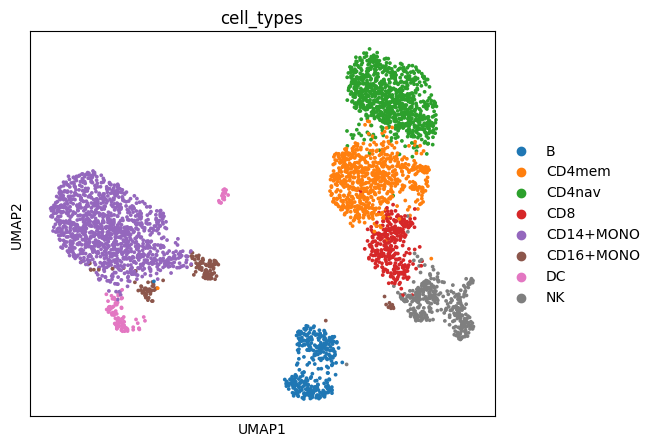

In [23]:
plt.rcParams['figure.figsize'] = [6, 5]
RNA=RNA[np.intersect1d(RNA.obs_names, df_ct.index)] 
RNA.obs["cell_types"] = df_ct.loc[RNA.obs_names]
sc.pl.umap(RNA, color=["cell_types"])

We inspect the number of cells for each cell type. The SPaRTAN model may require significant time and memory to run with large datasets. Sometimes, it's necessary to subset cells from larger cell types to prevent memory overflow.

In [24]:
RNA.obs["cell_types"].value_counts()

cell_types
CD14+MONO    1203
CD4nav        910
CD4mem        716
NK            353
B             332
CD8           319
CD16+MONO     139
DC             99
Name: count, dtype: int64

## pySPaRTAN execution
### Reviewing pySPaRTAN model

pySPaRTAN is constructed as a bilinear regression model. There are three inputs for the model:

D: each row represents a gene and each column is a binary vector representing the target genes of a TF

P: each row represents a cell and each column represents CLR normalized surface protein expression 

Y: log-normalized gene expression matrix where each column of Y corresponds to a cell 

The model learns the weight (interaction) matrix W between TFs and cell surface proteins that predicts TF-target gene expression.

<img src="pySPaRTAN_diagram_2.png" alt="Diagram" width="600" />



We convert this bilinear equation

<img src="equation_1.png" alt="Diagram" width="120" />

to an equivalent linear system of equations by reformulating the matrix products as Kronecker products and apply approximations to expedite its solution. Please refer to our paper
https://academic.oup.com/nar/article/49/17/9633/6368058 for detailed information on solving the equation.

Using the trained interaction matrix (W), we can predict 

1. TF activities from the cell surface protein expression profile.

2. protein activities from the cellular mRNA expression data and the TF-target gene hit matrix.


<img src="pySPaRTAN_diagram_3.png" alt="Diagram" width="600" />

### Generating pySPaRTAN input data

We load the curated gene-TF dataframe for PBMC dataset.

In [25]:
geneTF = pd.read_csv("../data/D_pbmc.csv", index_col=0)
geneTF.shape

(2643, 255)

Note: pySPaRTAN model requires log normalized RNA expression as input. Current RNA.X has been scaled during cell type annotation, we need to load the normalized data back to RNA.X.

In [26]:
RNA.X = RNA.layers['log1p']

In [27]:
# aligning the genes in RNA object with those in geneTF dataframe
RNA = RNA[:, geneTF.index]

We extract RNA and ADT data for each cell type. 
Note: here we convert the AnnData objects to Pandas dataframes.

In [28]:
RNAs={}; ADTs={}
for celltype in set(df_ct["cell_types"]):
    index_type = df_ct.index[df_ct["cell_types"]==celltype]
    RNA_type = RNA[RNA.obs_names.isin(index_type)].to_df()
    ADT_type = ADT[ADT.obs_names.isin(index_type)].to_df()

    RNAs[celltype] = RNA_type
    ADTs[celltype] = ADT_type

RNAs.keys()

dict_keys(['CD4nav', 'CD16+MONO', 'CD4mem', 'NK', 'DC', 'CD14+MONO', 'B', 'CD8'])

### Training cell-type specific pySPaRTAN model
After preparing the input for pySPaRTAN, we are ready to run the model. We will use the CD8 T cell to demonstrate the procedure.

In [29]:
ct = "CD8"
D = geneTF.copy()
P = ADTs[ct].copy()
Y = RNAs[ct].copy()

In [30]:
D.shape, P.shape, Y.shape

((2643, 255), (319, 29), (319, 2643))

Different cell types have varying number of cells for P and Y dataframes, whereas the gene-TF D dataframe maintains a fixed size across all cell types.

Before training the model, we recommend normalizing D, P, and Y using l2 normalization. P and Y are normalized within cells.

In [31]:
D = pd.DataFrame(normalize(D.values, axis=0), index=D.index, columns=D.columns)
P = pd.DataFrame(normalize(P.values, axis=1), index=P.index, columns=P.columns)
Y = pd.DataFrame(normalize(Y.values, axis=1), index=Y.index, columns=Y.columns)

P and Y represent normalized protein and RNA expressions, where each row represents a cell and each column represents a protein or a gene. 

Note: the values of P dataframe corresponds to the Pt in the diagram figure above.

pySPaRTAN is a regularized bilinear model that incorporates three hyperparameters: lambda, rsL2, and spectrum. Lambda and rsL2 control the trade-off between L1 and L2 regularization. Spectrum controls the truncation of the P matrix after singular value decomposition. For specific meaning of those hyperparameters, please refer to our paper https://academic.oup.com/nar/article/49/17/9633/6368058.

To tune these hyperparamters, We employ cross-validation and grid search to determine the optimal values of lambda (ranging from 1e-5 to 10) and rsL2 (ranging from 0 to 1). The spectrum parameter requires less tuning; hence, we fix it at 0.7.

We define the list of lambda, rsL2, spectrum and cross-validation fold as follows:

In [32]:
lamdas = [0.001, 0.01, 0.1]
rsL2s = [0.001, 0.01]
spectrums = [0.7]
# defining cross-validation fold
fold = 5

First we need to initiate the model with those parameters.

In [33]:
model = pySPaRTAN(lambdas = lamdas, rsL2s = rsL2s, spectrums=spectrums, n_fold=fold)

Then we train the model by passing the D, P, Y datasets.

In [34]:
model.fit(D=D, P=P, Y=Y)

cross validating  spectrum=0.7, lambda=0.001, rsL2=0.001
cross validating  spectrum=0.7, lambda=0.001, rsL2=0.01
cross validating  spectrum=0.7, lambda=0.01, rsL2=0.001
cross validating  spectrum=0.7, lambda=0.01, rsL2=0.01
cross validating  spectrum=0.7, lambda=0.1, rsL2=0.001
cross validating  spectrum=0.7, lambda=0.1, rsL2=0.01
Best parameters are: spectrum=0.7, lambda=0.001, rsL2=0.001 
The cross validation performance is 0.689 


Now, we can obtain the inferred TF activity for all CD8 T cells based on the their protein expression.

In [35]:
tf =model.get_projTF(P)
tf

,CREB1,JUN,TEAD1,FOS,RXRA,PBX3,MYC,RARA,PPARG,PAX6,...,SMARCC1,KMT2B,FOXO4,SSRP1,SMAD5,ZNF274,UBTF,ZNF592,TGIF2,GATAD1
AACACACCAATCCTAG-1,0.221581,0.116749,-0.300838,0.420604,-0.218103,0.122931,0.569785,0.017732,0.302746,-0.018329,...,0.239970,-0.111198,-0.088936,0.432762,0.112675,0.231312,0.081378,-0.307120,0.151516,0.210916
AACAGGGAGCGAAACC-1,0.235006,0.125654,-0.302341,0.345550,-0.161842,0.089513,0.558269,0.011609,0.332151,-0.019063,...,0.251530,-0.147863,-0.048125,0.511758,0.057514,0.296642,0.102601,-0.259679,0.185528,0.240914
AACCAACTCGAGTACT-1,0.169015,0.164535,-0.296869,0.368001,-0.126398,0.168697,0.610518,0.038898,0.365439,-0.021185,...,0.252646,-0.108349,-0.204480,0.618730,0.084059,0.221342,0.087005,-0.339790,0.076915,0.176774
AACCATGCAATGCAAA-1,0.273832,0.124932,-0.338101,0.402688,-0.189067,0.089811,0.573770,-0.002789,0.360929,-0.031385,...,0.294399,-0.147030,0.032685,0.529729,0.068063,0.342330,0.119737,-0.271546,0.238405,0.290397
AACGGGAGTGAGATAT-1,0.257455,0.148260,-0.336375,0.418455,-0.165243,0.103775,0.589109,-0.022231,0.357996,-0.024953,...,0.271132,-0.128854,0.004378,0.539511,0.064214,0.313677,0.091705,-0.295510,0.219923,0.282253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTCAGTAATGCTC-1,0.276957,0.129643,-0.358245,0.355937,-0.162133,0.081972,0.569712,-0.005990,0.370643,-0.025032,...,0.297359,-0.144193,0.051766,0.561257,0.046030,0.362971,0.107072,-0.262173,0.254324,0.305878
TTGTTGTGTACCTTCC-1,0.199842,0.149070,-0.288516,0.472791,-0.230031,0.147158,0.625178,0.016048,0.310887,-0.020548,...,0.227983,-0.139622,-0.168184,0.488882,0.126671,0.221857,0.094452,-0.325231,0.130022,0.199857
TTGTTTGTCGACCCAG-1,0.172328,0.150784,-0.285579,0.408153,-0.183833,0.161336,0.573629,0.018293,0.327117,-0.030636,...,0.254545,-0.155743,-0.145554,0.586591,0.117111,0.256455,0.098228,-0.295889,0.127106,0.224260
TTTAGTCTCGGTGCAC-1,0.215783,0.123052,-0.267282,0.453502,-0.219097,0.138278,0.623288,0.035727,0.344296,-0.016640,...,0.268812,-0.143329,-0.169325,0.494992,0.103566,0.210548,0.143309,-0.333869,0.109553,0.171340


## Analyzing results

Here we explore the associations between inferred TF activity and surface protein expression at a single-cell level.

We first compute Pearson correlation coefficients between inferred TF activity and surface protein expression for each TF-protein pair within the cell-type.

In [36]:
tf_protein = model.get_tf_protein_cor(P)
tf_protein

,CD3_TotalSeqB,CD4_TotalSeqB,CD8a_TotalSeqB,CD11b_TotalSeqB,CD14_TotalSeqB,CD15_TotalSeqB,CD16_TotalSeqB,CD19_TotalSeqB,CD20_TotalSeqB,CD25_TotalSeqB,...,CD86_TotalSeqB,CD127_TotalSeqB,CD137_TotalSeqB,CD197_TotalSeqB,CD274_TotalSeqB,CD278_TotalSeqB,CD335_TotalSeqB,PD-1_TotalSeqB,HLA-DR_TotalSeqB,TIGIT_TotalSeqB
CREB1,-0.424472,-0.642362,0.633641,-0.431235,-0.184781,-0.308417,-0.243081,-0.177414,0.298939,-0.045521,...,-0.020474,0.086146,-0.020800,-0.142421,-0.188374,-0.316033,-0.295488,-0.060510,-0.061636,0.230757
JUN,0.387325,0.735389,-0.776577,0.224484,0.188679,0.358378,0.263951,0.201211,-0.039022,0.128938,...,-0.005179,0.428158,0.016111,0.295634,0.219404,0.290449,0.307566,0.098277,-0.116990,-0.166163
TEAD1,-0.001045,0.076261,0.195311,0.234698,0.002156,-0.090080,0.123510,0.046052,-0.351203,-0.118611,...,0.019478,-0.585536,-0.005675,-0.154333,-0.033624,0.157883,0.085403,-0.214563,0.169261,0.070563
FOS,-0.152831,0.127539,0.180320,0.012936,-0.080555,-0.127972,0.190136,0.044383,-0.259809,-0.226445,...,-0.013333,-0.490957,0.046968,-0.053062,-0.002493,0.209276,0.114402,0.062732,-0.026370,0.515909
RXRA,0.319177,-0.148348,-0.303162,-0.024560,0.138138,0.207019,-0.070217,-0.025964,0.255761,0.288063,...,0.046589,0.532123,0.067275,0.138126,-0.038763,-0.253948,-0.007879,-0.337740,0.073693,-0.307098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNF274,-0.245809,-0.124299,0.029928,-0.404807,-0.088209,-0.095430,-0.203609,-0.080019,0.387534,0.064059,...,-0.043022,0.619189,-0.040736,0.023610,-0.049612,-0.174626,-0.216570,0.215133,-0.179665,-0.074314
UBTF,-0.213270,0.670465,0.029494,-0.012600,-0.062378,-0.135669,-0.060691,0.080866,-0.155764,-0.152287,...,0.024349,-0.019910,-0.008592,-0.028141,0.011687,0.735313,-0.231462,0.491507,-0.013502,-0.293609
ZNF592,-0.363746,0.474076,-0.351920,-0.254695,-0.055625,-0.048596,-0.144645,0.013753,0.214509,0.039255,...,-0.059841,0.640892,-0.057983,-0.014310,0.031835,0.016962,-0.132546,0.443296,-0.140935,-0.298422
TGIF2,-0.419258,0.043880,-0.017498,-0.335759,-0.118387,-0.135458,-0.192550,-0.079082,0.326119,0.026176,...,-0.047231,0.577603,-0.017287,0.037754,-0.047246,-0.112098,-0.218047,0.371447,-0.205132,-0.090310


In [37]:
#trimming the end of protein names
tf_protein.columns = tf_protein.columns.str[:-10]
tf_protein.columns

Index(['CD3', 'CD4', 'CD8a', 'CD11b', 'CD14', 'CD15', 'CD16', 'CD19', 'CD20',
       'CD25', 'CD27', 'CD28', 'CD34', 'CD45RA', 'CD45RO', 'CD56', 'CD62L',
       'CD69', 'CD80', 'CD86', 'CD127', 'CD137', 'CD197', 'CD274', 'CD278',
       'CD335', 'PD-1', 'HLA-DR', 'TIGIT'],
      dtype='object')

We select the TFs and proteins with high absolute correlation values. 

In [38]:
proteins_to_plot = tf_protein.columns[abs(tf_protein).max(axis=0) > 0.7]
tfs_to_plot = tf_protein.index[abs(tf_protein).max(axis=1) > 0.85]
tf_protein_plot = tf_protein.loc[tfs_to_plot, proteins_to_plot]

Then we plot cluster heatmap to show the clustering of the protein-TF correlations.

Text(0.5, 1.05, 'CD8 T cell protein-TF correlation')

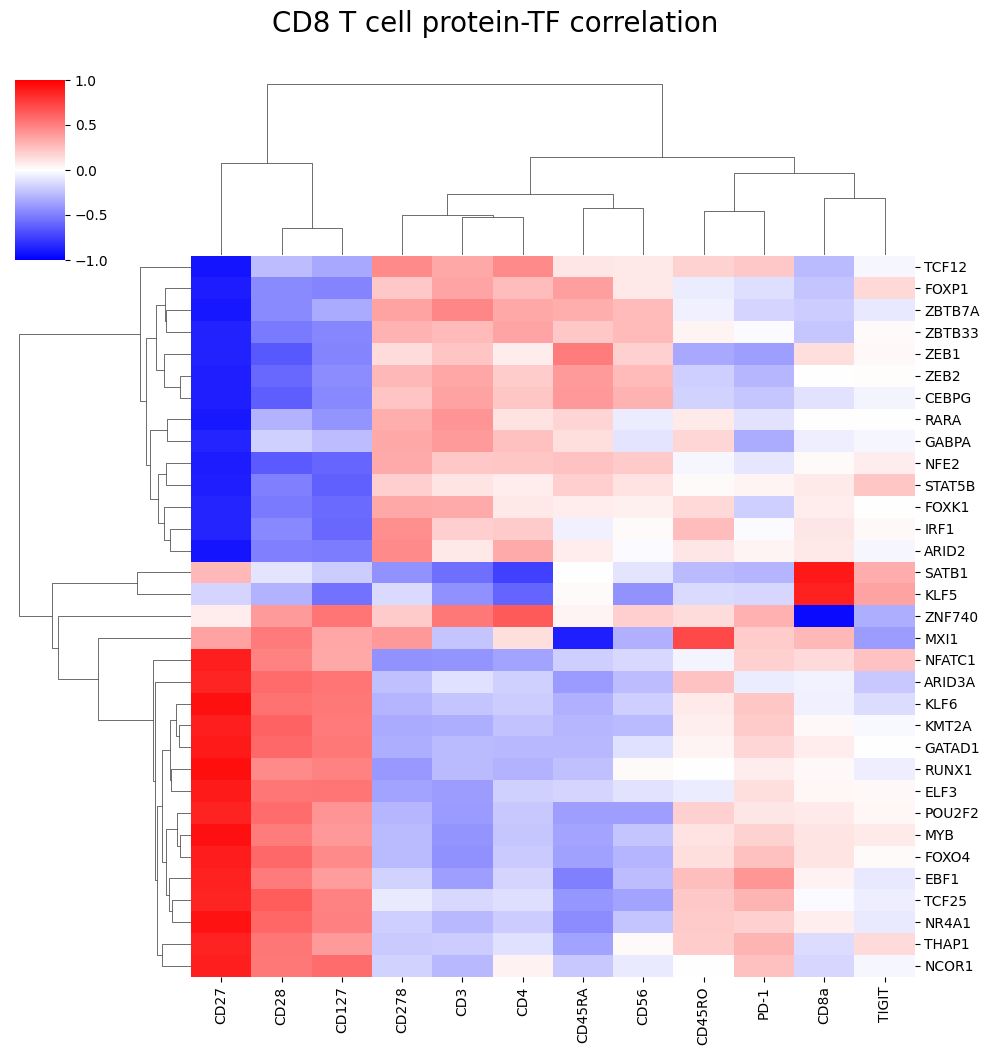

In [39]:
sns.clustermap(
    tf_protein_plot,
    cmap="bwr",vmin=-1, vmax=1
).fig.suptitle(ct + " T cell protein-TF correlation", y=1.05,fontsize=20)

Alternatively, we plot the correlations between TFs and a specific protein, highlighting the TFs with high and low correlations.

In [40]:
# defining the plot function
def line_plot(pcc,prot, N, ax):
    
    pcc_prot = pcc.loc[:, prot].sort_values()

    labels = pcc_prot.index

    x= range(1,len(pcc_prot)+1)
    y=pcc_prot

    ax.scatter(x, y, s=8)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    texts = [ax.text(x[i], y[i], '%s' %labels[i], ha='center', va='center', fontsize=10) for i in range_c]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r'), ax=ax, min_arrow_len=0, time_lim=0.1)

    ax.set_xlabel("TF ranking", fontsize=15)
    ax.set_ylabel(f"Corr between {prot} exp and TF activity", fontsize=15)
    ax.set_title(prot)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    TF_labels = [labels[i] for i in range_c]
    return(TF_labels)


We create a line plot of TF correlations with the protein of interest and annotate the N TFs with the highest and lowest correlations.

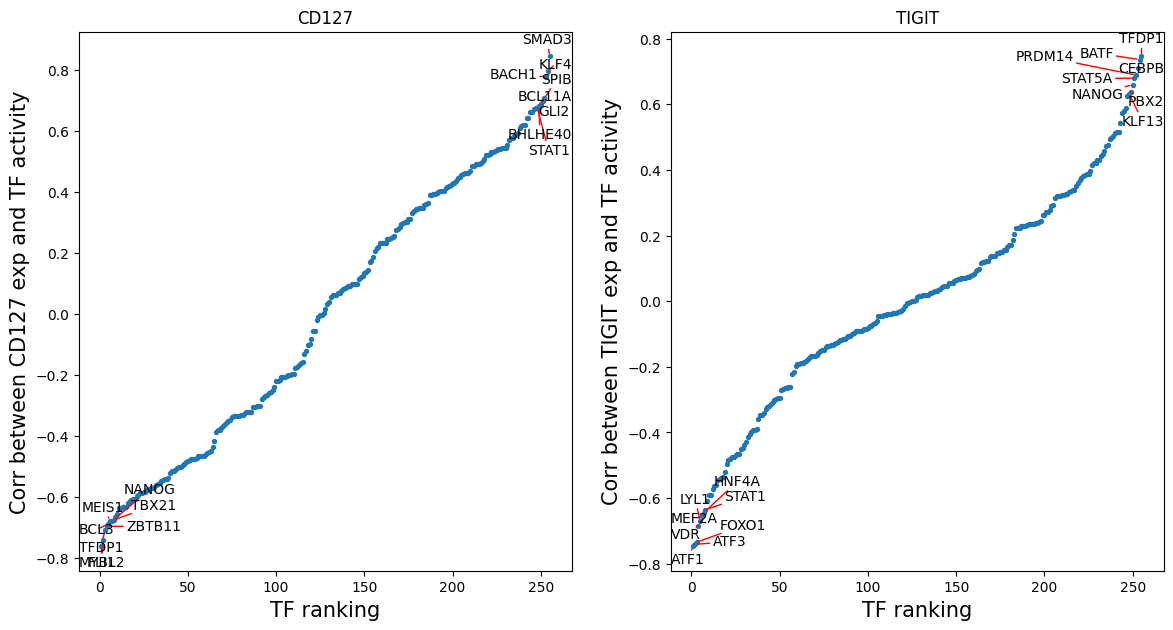

In [41]:
plt.rcParams['figure.figsize'] = [14, 7]
fig, ax = plt.subplots(1,2)
prot = "CD127"
line_plot(tf_protein, prot, 8, ax[0])
prot = "TIGIT"
line_plot(tf_protein, prot, 8, ax[1])

fig.show()


From the lineplots above, we observed several known correlated TF-surface protein pairs in CD8 T cells, such as SMAD3-CD127 and STAT5-TIGIT.